In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

### Load up data and classifier

In [7]:
qda = pkl.load(open("./results/gemma-2-2b/projected_shades_reformated_qda.pkl", "rb"))
data = pd.read_csv("./results/gemma-2-2b/projected_shades_reformated.csv")

### Plot data and decision boundaries

In [25]:
data = data[data["class"] != "probable"]

features = data[["improbable_impossible", "impossible_inconceivable"]]
classes = data["class"]
sentences = data["sentence"]

clf_classes = qda.classes_
print(clf_classes)
distributions = qda.predict_proba(features)

['impossible' 'improbable' 'inconceivable']


/gpfs/data/epavlick/mlepori/miniconda3/envs/content_effects/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


(100, 100)


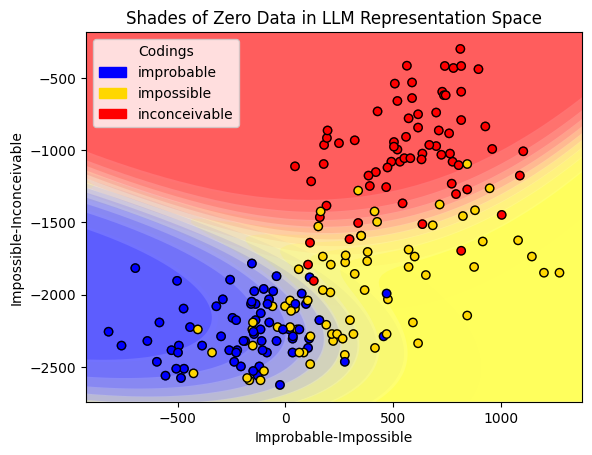

In [56]:
import matplotlib.patches as mpatches
import numpy as np

plt.Figure()

fig, ax = plt.subplots()

colors = []
for cl in classes:
    if cl == "improbable":
        colors.append("blue")

    if cl == "impossible":
        colors.append("gold")
    
    if cl == "inconceivable":
        colors.append("red")

legend_colors = {
    'improbable': 'blue',
    'impossible': 'gold',
    'inconceivable': 'red'
}

# Create legend patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]

ax.scatter(x=features["improbable_impossible"], y=features["impossible_inconceivable"], c=colors)
plt.legend(handles=legend_handles, title="Codings")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100),
    np.linspace(ylim[0], ylim[1], 100)
)

grid_points = np.c_[xx.ravel(), yy.ravel()] 
bg_probs = qda.predict_proba(grid_points)

impossible_bg_probs = bg_probs[:, 0].reshape(xx.shape)
print(impossible_bg_probs.shape)
improbable_bg_probs = bg_probs[:, 1].reshape(xx.shape)
inconceivable_bg_probs = bg_probs[:, 2].reshape(xx.shape)

# Loop over probability levels and draw a contour layer for each
levels = np.linspace(0.01, 0.9, 10)
for level in levels:
    ax.contourf(xx, yy, impossible_bg_probs,
                levels=[level, 1],
                colors='yellow',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    ax.contourf(xx, yy, improbable_bg_probs,
                levels=[level, 1],
                colors='blue',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    ax.contourf(xx, yy, inconceivable_bg_probs,
                levels=[level, 1],
                colors='red',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    
ax.scatter(x=features["improbable_impossible"], y=features["impossible_inconceivable"], c=colors, edgecolors="black")
plt.title("Shades of Zero Data in LLM Representation Space")
plt.ylabel("Impossible-Inconceivable")
plt.xlabel("Improbable-Impossible")
plt.savefig("./results/gemma-2-2b/shades_regions.pdf", format="pdf")

### Find most controversial datapoint: Highest entropy in distribution between adjoining classses

In [55]:
import scipy.stats as stats

prob_data = pd.read_csv("./results/gemma-2-2b/QDA_Projections_projected_shades_reformated.csv")

boundary_epsilon = .15
other_class_epsilon = .1

for _, row in prob_data.iterrows():

    improb = row["improbable"]
    imposs = row["impossible"]
    inc = row["inconceivable"]
    sent = row["sentence"]

    if np.abs(improb - imposs) < boundary_epsilon and inc < other_class_epsilon:
        print("\nBoundary Improb Imposs")
        print(sent)

    if np.abs(inc - imposs) < boundary_epsilon and improb < other_class_epsilon:
        print("\nBoundary Imposs Inc")
        print(sent)



Boundary Improb Imposs
boiling water using a refrigerator.

Boundary Improb Imposs
calling a friend using a laptop.

Boundary Improb Imposs
chilling a drink using fire.

Boundary Imposs Inc
climbing a tree using a poem.

Boundary Imposs Inc
closing a jacket using fog.

Boundary Imposs Inc
digging a hole using a yawn.

Boundary Improb Imposs
docking a boat using an anvil.

Boundary Improb Imposs
docking a boat using a balloon.

Boundary Imposs Inc
filling a bucket with buildings.

Boundary Improb Imposs
hiding a gift inside a forest.

Boundary Imposs Inc
making a sandwich using a mile.

Boundary Improb Imposs
shattering a window using a frisbee.

Boundary Improb Imposs
shaving their beard using a teabag.

Boundary Improb Imposs
squishing a blueberry using their breath.

Boundary Improb Imposs
starting a fire using furniture.
